In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import yaml
from IPython.core.display import HTML
from IPython.display import display
import warnings

from oml.lightning.pipelines.validate import extractor_validation_pipeline
from oml.lightning.callbacks.metric import MetricValCallback
from oml.const import MOCK_DATASET_PATH
from oml.utils.download_mock_dataset import download_mock_dataset

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 330)

warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
download_mock_dataset(MOCK_DATASET_PATH);

In [2]:
cfg = f"""
    dataset_root: {MOCK_DATASET_PATH}
    dataframe_name: df_with_category.csv
    logs_root: logs
    bs_val: 128
    num_workers: 0
    
    transforms_val:
      name: norm_resize_albu
      args:
        im_size: 224

    extractor:
      name: vit
      args:
        arch: vits16
        normalise_features: False
        use_multi_scale: False
        weights: vits16_dino

    metric_args:
      cmc_top_k: [1]
      map_top_k: [5]
      
    accelerator: cpu
    devices: 1
  
"""
        
trainer, ret_dict = extractor_validation_pipeline(yaml.load(cfg, Loader=yaml.Loader));

clb_metric = [x for x in trainer.callbacks if isinstance(x, MetricValCallback)][0]

{'accelerator': 'cpu',
 'bs_val': 128,
 'dataframe_name': 'df_with_category.csv',
 'dataset_root': '/Users/alex/Library/Caches/oml/mock_dataset',
 'devices': 1,
 'extractor': {'args': {'arch': 'vits16',
                        'normalise_features': False,
                        'use_multi_scale': False,
                        'weights': 'vits16_dino'},
               'name': 'vit'},
 'logs_root': 'logs',
 'metric_args': {'cmc_top_k': [1], 'map_top_k': [5]},
 'num_workers': 0,
 'transforms_val': {'args': {'im_size': 224}, 'name': 'norm_resize_albu'}}
https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth
Checkpoint is already here.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/alex/Projects/open-metric-learning/pipelines/features_extraction/lightning_logs


Validation: 0it [00:00, ?it/s]


Metrics:
{'OVERALL': {'cmc': {1: tensor(1.)},
             'map': {5: tensor(0.8625)},
             'pcf': {0.5: tensor(0.0052)},
             'precision': {5: tensor(1.)}},
 'closed': {'cmc': {1: tensor(1.)},
            'map': {5: tensor(0.8750)},
            'pcf': {0.5: tensor(0.0026)},
            'precision': {5: tensor(1.)}},
 'open': {'cmc': {1: tensor(1.)},
          'map': {5: tensor(0.8500)},
          'pcf': {0.5: tensor(0.0052)},
          'precision': {5: tensor(1.)}}}


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       OVERALL/cmc/1       │            1.0            │
│       OVERALL/map/5       │     0.862500011920929     │
│      OVERALL/pcf/0.5      │   0.0052083334885537624   │
│    OVERALL/precision/5    │            1.0            │
│       closed/cmc/1        │            1.0            │
│       closed/map/5        │           0.875           │
│      closed/pcf/0.5       │   0.0026041667442768812   │
│    closed/precision/5     │            1.0            │
│        open/cmc/1         │            1.0            │
│        open/map/5         │    0.8500000834465027     │
│       open/pcf/0.5        │   0.0052083334885537624   │
│     open/precision/5      │            1.0            │
└───────────────────────────┴───────────────────────────┘

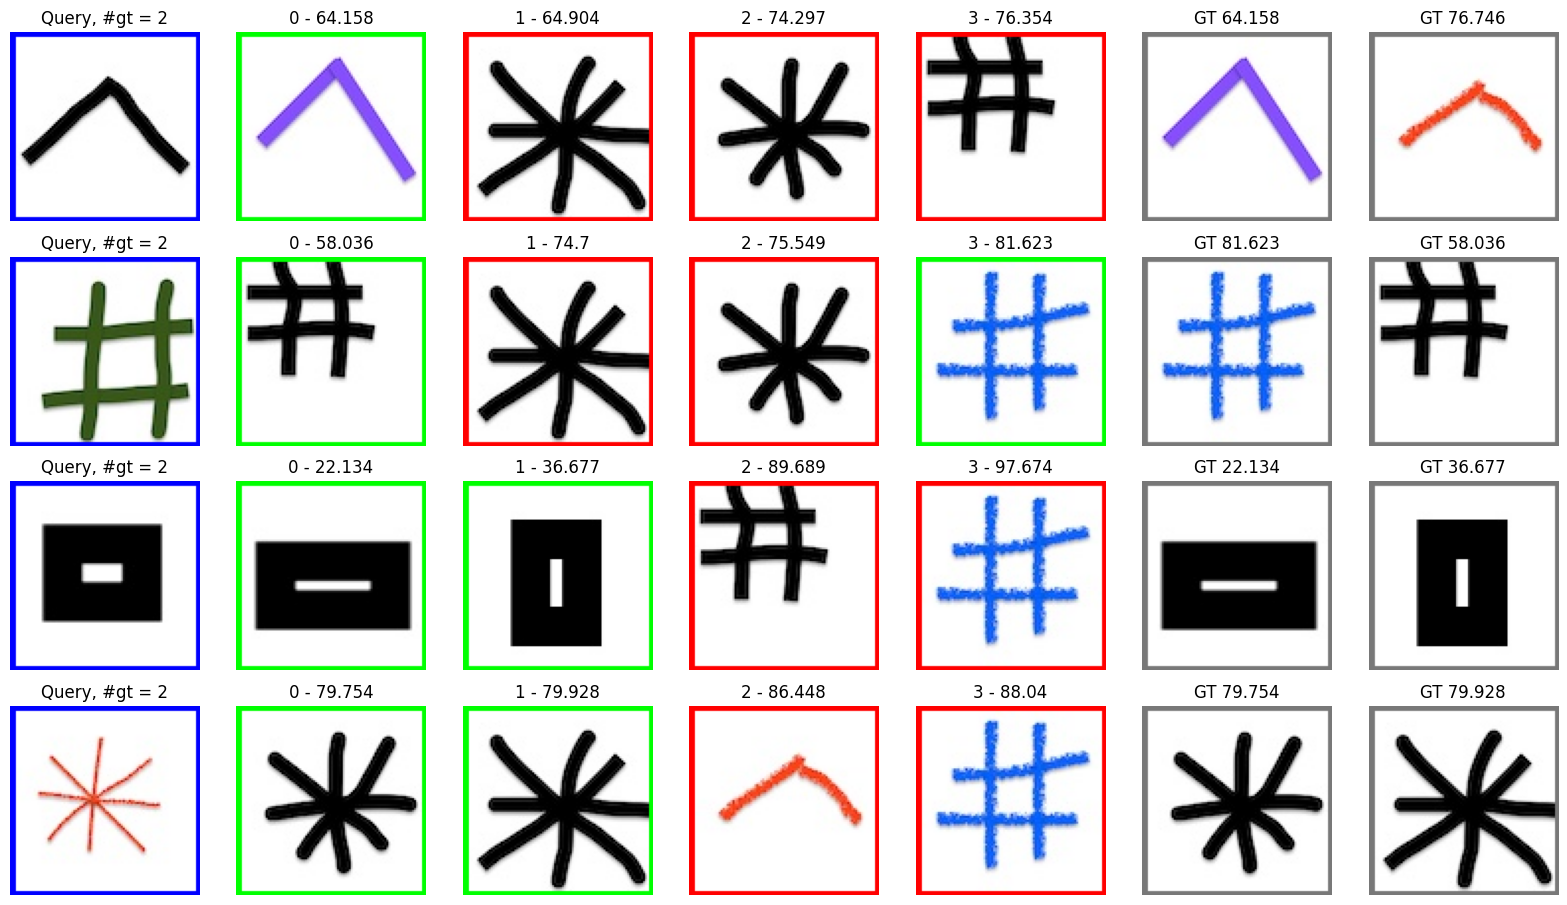

In [3]:
n_query = min(10, clb_metric.metric.distance_matrix.shape[0])
fig = clb_metric.metric.get_plot_for_worst_queries(metric_name='OVERALL/map/5', n_queries=n_query, n_instances=4, verbose=False)

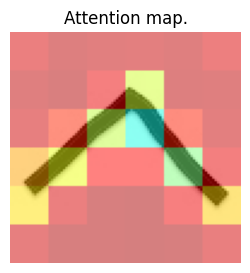

In [4]:
from oml.utils.images.images import imread_cv2
import matplotlib.pyplot as plt

im_path = clb_metric.metric.acc.storage["paths"][0]
model = trainer.lightning_module.model

img = imread_cv2(im_path)
img_attn = model.draw_attention(img)

plt.figure(figsize=(3, 3))
plt.title("Attention map.")
plt.imshow(img_attn)
plt.axis("off")
plt.show()
